In [1]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.discrete.Discrete(3)
        """STATE INCLUDES:
        - attack_x: x-coordinate of the attack point (Low: -1, High: 1)
        - attack_y: y-coordinate of the attack point (Low: -1, High: 1)
        - defense_x: x-coordinate of the defense point (Low: -1, High: 1)
        - defense_y: y-coordinate of the defense point (Low: -1, High: 1)
        - theta: angle between the defense and the attack point (low: 0, high: 2*pi)
        - missile_angle: angle of the missile (low: 0, high: 2*pi)
        - difference in of theta and missile_angle (low: 0, high: pi)
        - distance: distance between the defense and attack point (low: 0, high: 2.9)
        - theta in sin form (low: -1, high: 1)
        - theta in cos form (low: -1, high: 1)
        - missile_angle in sin form (low: -1, high: 1)
        - missile_angle in cos form (low: -1, high: 1)
        - delta_sin: difference in sin form between theta and missile_angle (low: -2, high: 2)
        - delta_cos: difference in cos form between theta and missile_angle (low: -2, high: 2)
        """
        low = np.array([-1, -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, -2, -2])
        high = np.array([1, 1, 1, 1, 2*math.pi, 2*math.pi, math.pi, 2.9, 1, 1, 1, 1, 2, 2])
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0
        self.distance_t_minus_one = 0
        self.distance_change = 0

        self.out_of_bounds = 0
        self.interceptions = 0
        self.reached_max_steps = 0

        self.defense_positions = []
        self.attack_positions = []

        self.max_steps_per_episode = 150

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_defense()
        self.create_attack(self.defense)
        self.calc_angle(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        # self.graph(self.defense, self.attack)
        self.get_state()

        return self.state, {}

    def create_defense(self):
        x = random.uniform(-0.45, 0.45)
        y = random.uniform(-0.45, 0.45)
        self.defense = np.array([x, y])

    def create_attack(self, defense):
        x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
        x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
        y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
        y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_angle(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.theta = self.theta # 1st quadrant
            else: 
                self.theta = (2*math.pi) - self.theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.theta = math.pi - self.theta # 180 - theta
            else:
                self.theta = math.pi + self.theta # 180 + theta
            
        return self.theta
    
    def initial_missile_angle(self):
        self.missile_angle = np.random.uniform(0, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.missile_angle)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.missile_angle))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):
        self.missile_distance_to_attack()

        if self.distance < 0:
            print("HIT!")
            self.reward = 10000
            self.done = True
            self.interceptions += 1
        else:
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            self.reward = 1/self.angle_diff
                
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            print("OUT OF BOUNDS")
            self.reward = -1000
            self.done = True
            self.out_of_bounds += 1

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle

    def get_state(self):
        self.angle_conversion()

        self.state = np.array([
            self.attack[0], self.attack[1], 
            self.defense[0], self.defense[1], 
            self.theta, self.missile_angle,
            min(abs(self.theta - self.missile_angle), 2*math.pi - abs(self.theta - self.missile_angle)),
            self.distance,
            self.sin_theta, self.cos_theta, 
            self.sin_missile_angle, self.cos_missile_angle,
            self.delta_sin, self.delta_cos
        ])

    def get_state_dict(self):
        return {
            "attack_x": self.attack[0],
            "attack_y": self.attack[1],
            "defense_x": self.defense[0],
            "defense_y": self.defense[1],
            "theta": self.theta,
            "missile_angle": self.missile_angle,
            "difference in theta and missile_angle": min(abs(self.theta - self.missile_angle), 2*math.pi - abs(self.theta - self.missile_angle)),
            "distance": self.distance,
            "sin_theta": self.sin_theta,
            "cos_theta": self.cos_theta,
            "sin_missile_angle": self.sin_missile_angle,
            "cos_missile_angle": self.cos_missile_angle,
            "delta_sin": self.delta_sin,
            "delta_cos": self.delta_cos
        }
                 
    def step(self, action):
        self.distance_t_minus_one = self.distance
        self.missile_nav_angle(action)
        self.missle_coord_calc()
        self.calc_angle(self.defense, self.attack)
        self.calculate_reward()
        self.current_step += 1

        if self.current_step >= self.max_steps_per_episode:
            print("MAX STEPS REACHED")
            self.done = True
            self.reward = -1000
            self.reached_max_steps += 1

        self.get_state()
        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')

        ax.set_aspect('equal')
        plt.show()

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML, display


def animate_episode(episode_data, save_name):
    episode_past_defense_positions = episode_data["past_defense_positions"]
    past_defense_x, past_defense_y = zip(*episode_past_defense_positions)
    episode_attack_positions = episode_data["attack_positions"]
    attack_x, attack_y = zip(*episode_attack_positions)
    episode_defense_positions = episode_data["defense_positions"]
    defense_x, defense_y = zip(*episode_defense_positions)

    # Create figure and axis
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    trail, = ax.plot([], [], 'b-', label='Defense Trail')  
    scatter1, = ax.plot([], [], 'ro')  # 'ro' means red circles
    scatter2, = ax.plot([], [], 'bo')  # 'ro' means red circles

    # Update function for animation
    def update(frame):
        trail.set_data(past_defense_x[:frame+1], past_defense_y[:frame+1])
        scatter1.set_data(attack_x[frame], attack_y[frame])
        scatter2.set_data(defense_x[frame], defense_y[frame])
        return trail, scatter1, scatter2

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(past_defense_x), interval=200, blit=True)

    # Option 1: Save animation
    ani.save(save_name, writer='pillow')
    print(f"Animation saved as {save_name}")

    # # Option 2: Display using HTML
    # plt.close(fig)
    # video = ani.to_html5_video()
    # html = display(HTML(video))

    plt.show()

Using cpu device
Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.8     |
|    ep_rew_mean      | -980     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 546      |
|    time_elapsed     | 0        |
|    total_timesteps  | 215      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 31.3     |
|    n_updates        | 28       |
----------------------------------
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.6     |
|    ep_rew_mean      | -980     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 575      |
|   

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_2_v8.1_dqn_bone_angle.gif


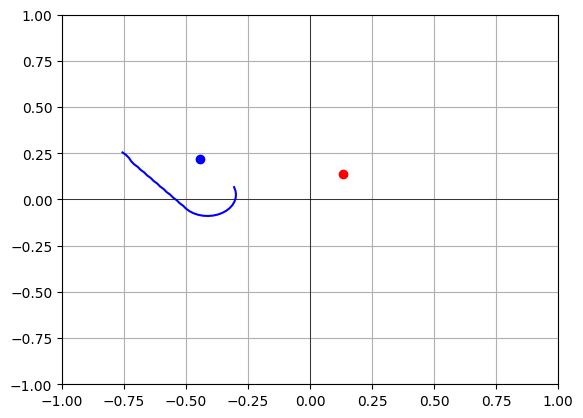

Missile angles:  [4.992902, 4.818369, 4.643836, 4.469303, 4.2947702, 4.1202374, 3.9457042, 3.7711713, 3.5966384, 3.4221056, 3.2475724, 3.0730395, 2.8985066, 2.7239738, 2.5494409, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.374908, 2.200375, 2.025842, 2.200375, 2.374908, 5.7032585]
Theta angles:  [2.6722856, 2.6416318, 2.608961, 2.5748615, 2.539882, 2.5045452, 2.4693644, 2.4348571, 2.40156, 2.3700442, 2.3409305, 2.3149061, 2.2927387, 2.2752886, 2.263514, 2.2584612, 2.2612255, 2.255556, 2.2584572, 2.2520087, 2.2550411, 2.2475798, 2.2507198, 2.2418945, 2.2450783, 2.2343307, 2.2374039, 2.2237742, 2.2263575, 2.2080157, 2.2090964, 2.1819715, 2.1783533, 2.2154126, 2.2202625, 2.1474752, 3.0028348]


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.8     |
|    ep_rew_mean      | 1.1e+04  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 210      |
|    time_elapsed     | 0        |
|    total_timesteps  | 100122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 628      |
|    n_updates        | 25005    |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.2     |
|    ep_rew_mean      | 1.11e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 418      |
|    time_elapsed     | 0        |
|    total_timesteps  | 100313   |
| train/              |     

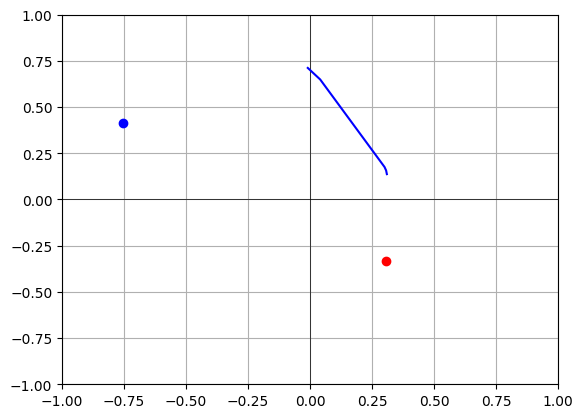

Missile angles:  [1.7229294, 1.8974622, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.0719953, 2.2465281, 2.2465281, 2.2465281, 2.2465281, 5.015714]
Theta angles:  [2.0945961, 2.1003923, 2.1012583, 2.1021786, 2.1031587, 2.1042047, 2.105323, 2.1065218, 2.1078103, 2.1091983, 2.1106985, 2.1123245, 2.114093, 2.1160238, 2.11814, 2.1204698, 2.1230469, 2.1259134, 2.1291203, 2.1327326, 2.1368318, 2.1415234, 2.1469452, 2.1532826, 2.1607873, 2.169814, 2.1808758, 2.1947439, 2.2126338, 2.2068362, 2.198648, 2.186208, 2.165054, 2.530102]
Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
HIT!

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 


HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.4     |
|    ep_rew_mean      | 3.03e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4004     |
|    fps              | 557      |
|    time_elapsed     | 0        |
|    total_timesteps  | 200182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 355      |
|    n_updates        | 50020    |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.5     |
|    ep_rew_mean      | 3.03e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4008     |
|    fps              | 571      |
|    time_elapsed     | 0        |
|    total_timesteps  | 200352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 

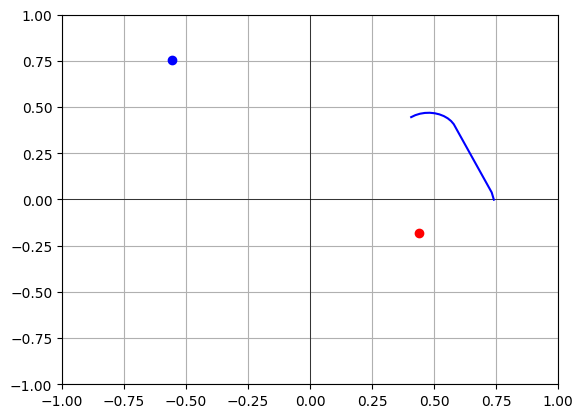

Missile angles:  [0.5670911, 0.3925582, 0.21802525, 0.04349233, -0.1310406, -0.30557352, -0.48010644, -0.65463936, -0.8291723, -1.0037053, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.1782382, -1.352771, -1.352771, 3.7272472]
Theta angles:  [5.2844234, 5.251704, 5.219834, 5.189352, 5.160832, 5.134896, 5.1122246, 5.0935693, 5.0797553, 5.0716743, 5.070262, 5.0687246, 5.0670443, 5.065201, 5.063169, 5.0609183, 5.0584116, 5.0556026, 5.0524325, 5.0488276, 5.0446925, 5.0399003, 5.0342813, 5.0276017, 5.019531, 5.009585, 4.9970284, 4.980683, 4.9585443, 4.926908, 4.925937, 4.9242234, 2.3861592]
Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
HIT!

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 


HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.1     |
|    ep_rew_mean      | 1.09e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6096     |
|    fps              | 712      |
|    time_elapsed     | 0        |
|    total_timesteps  | 300242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 420      |
|    n_updates        | 75035    |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.4     |
|    ep_rew_mean      | 1.08e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6100     |
|    fps              | 782      |
|    time_elapsed     | 0        |
|    total_timesteps  | 300394   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss          

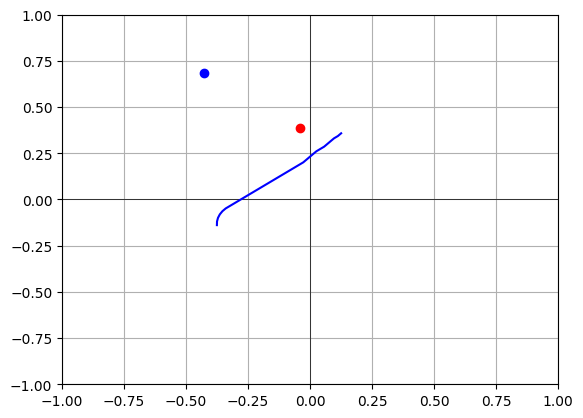

Missile angles:  [1.5457923, 1.3712595, 1.1967264, 1.0221936, 0.84766066, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.6731277, 0.84766066, 0.84766066, 0.84766066, 0.84766066, 0.6731277, 0.6731277, 0.84766066, 0.84766066, 0.84766066, 0.6731277, 0.84766066, 0.35391396]
Theta angles:  [0.7637352, 0.7478313, 0.73543036, 0.7271205, 0.7234816, 0.72505224, 0.72672385, 0.72850657, 0.7304118, 0.73245275, 0.73464423, 0.73700356, 0.7395509, 0.74230945, 0.7453067, 0.7485748, 0.7521523, 0.75608516, 0.7604289, 0.7652513, 0.77063584, 0.7766865, 0.7835345, 0.79134786, 0.8003448, 0.79643935, 0.79183185, 0.7863147, 0.7795895, 0.7926723, 0.80939835, 0.8031594, 0.79449177, 0.7816371, 0.81611073, 0.80138886, 2.490628]
Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
HIT!

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.09e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8208     |
|    fps              | 176      |
|    time_elapsed     | 0        |
|    total_timesteps  | 400033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 321      |
|    n_updates        | 99983    |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.2     |
|    ep_rew_mean      | 1.1e+04  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8212     |
|    fps              | 660      |
|    time_elapsed     | 0        |
|    total_timesteps  | 400283   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.1     |

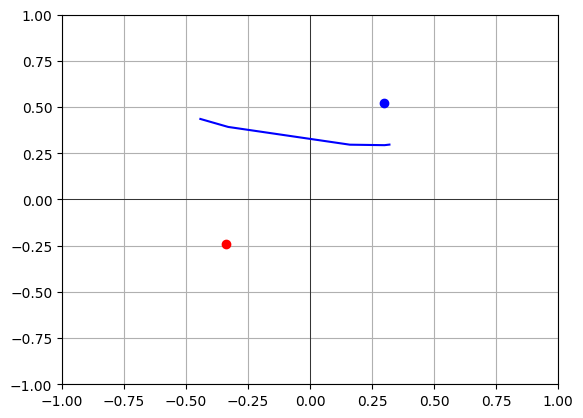

Missile angles:  [3.2972832, 3.1227503, 3.1227503, 3.1227503, 3.1227503, 3.1227503, 3.1227503, 3.1227503, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.9482174, 2.7736845, 2.7736845, 2.7736845, 2.7736845, 2.7736845, 2.7736845, 4.155973]
Theta angles:  [2.9383497, 2.9336467, 2.9287004, 2.9234922, 2.9180005, 2.9122024, 2.9060714, 2.8995788, 2.8980649, 2.8964536, 2.8947356, 2.8928998, 2.8909335, 2.8888226, 2.8865502, 2.8840973, 2.8814418, 2.878557, 2.875412, 2.8719702, 2.8681877, 2.8640113, 2.859376, 2.8542023, 2.848391, 2.841817, 2.8343196, 2.8256915, 2.8156574, 2.8038456, 2.7897425, 2.7726169, 2.751395, 2.7483134, 2.7442436, 2.7386193, 2.7303405, 2.7169492, 2.691611, 0.87439257]
Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | 1.19e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10308    |
|    fps              | 559      |
|    time_elapsed     | 0        |
|    total_timesteps  | 500161   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.85     |
|    n_updates        | 125015   |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | 1.19e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10312    |
|    fps              | 742      |
|    time_elapsed     | 0        |
|    total_timesteps  | 500325   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss           

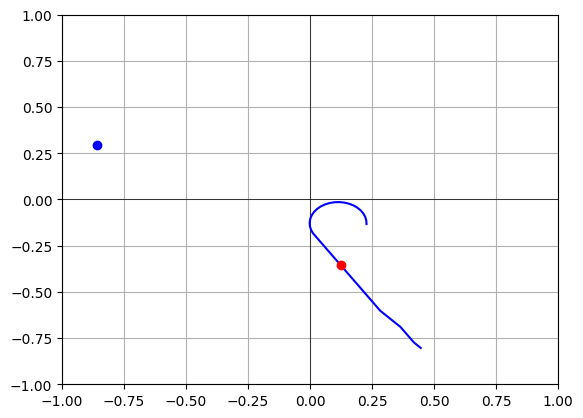

Missile angles:  [1.6212738, 1.7958066, 1.9703395, 2.1448724, 2.3194053, 2.4939384, 2.6684713, 2.8430042, 3.017537, 3.19207, 3.366603, 3.5411358, 3.715669, 3.8902018, 4.0647345, 4.239268, 4.4138007, 4.5883336, 4.7628665, 4.9373994, 5.1119323, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.460998, 5.460998, 5.460998, 5.460998, 5.460998, 5.460998, 5.286465, 5.286465, 5.286465, 5.286465, 5.286465, 5.460998, 5.460998, 1.8245867]
Theta angles:  [5.042162, 5.039538, 5.041309, 5.0471125, 5.0565233, 5.0690813, 5.0843124, 5.101745, 5.1209135, 5.141361, 5.1626425, 5.1843176, 5.20595, 5.227103, 5.2473373, 5.2662034, 5.283244, 5.297992, 5.3099737, 5.3187175, 5.3237677, 5.3247085, 5.3256974, 5.326739, 5.3278375, 5.328997, 5.330224, 5.3315234, 5.332903, 5.3343687, 5.3359303, 5.3375974, 5.3393803, 5

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.7     |
|    ep_rew_mean      | 1.16e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12372    |
|    fps              | 196      |
|    time_elapsed     | 0        |
|    total_timesteps  | 600058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 313      |
|    n_updates        | 149989   |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.5     |
|    ep_rew_mean      | 1.16e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12376    |
|    fps              | 217      |
|    time_elapsed     | 0        |
|    total_timesteps  | 600213   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.81  

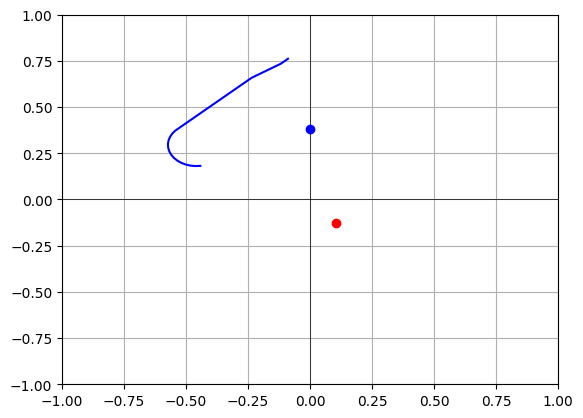

Missile angles:  [3.1921556, 3.0176227, 2.8430898, 2.6685567, 2.4940238, 2.319491, 2.144958, 1.9704251, 1.7958921, 1.6213592, 1.4468263, 1.2722933, 1.0977604, 0.92322755, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.7486946, 0.57416165, 0.57416165, 0.57416165, 0.57416165, 0.57416165, 0.57416165, 0.57416165, 0.7486946, 0.7486946, 5.4401636]
Theta angles:  [0.97888315, 0.9548641, 0.92951727, 0.90334004, 0.87681645, 0.85042477, 0.8246455, 0.79996926, 0.7769036, 0.75597984, 0.7377566, 0.72282124, 0.71178466, 0.705268, 0.70387685, 0.7023937, 0.70080906, 0.69911224, 0.69729084, 0.6953307, 0.69321525, 0.69092536, 0.68843853, 0.68572825, 0.6827631, 0.67950535, 0.67590946, 0.6719201, 0.66746914, 0.6624717, 0.6568208, 0.6503798, 0.6429712, 0.6343604, 0.6242303, 0.6291066, 0.6350338, 0.64239216, 0.6517701, 0.6641288, 0.681

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.2     |
|    ep_rew_mean      | 1.16e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14396    |
|    fps              | 904      |
|    time_elapsed     | 0        |
|    total_timesteps  | 700327   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.5     |
|    n_updates        | 175056   |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.6     |
|    ep_rew_mean      | 1.16e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14400    |
|    fps              | 871      |
|    time_elapsed     | 0        |
|    total_timesteps  | 700528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss      

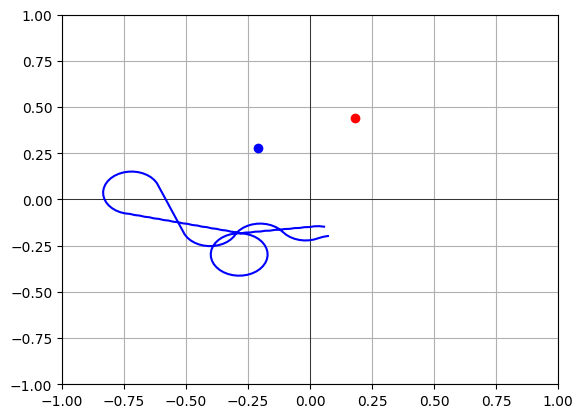

Missile angles:  [3.3506498, 3.5251827, 3.5251827, 3.3506498, 3.176117, 3.001584, 2.8270512, 2.6525183, 2.4779851, 2.3034523, 2.3034523, 2.4779851, 2.6525183, 2.8270512, 3.001584, 3.176117, 3.3506498, 3.5251827, 3.6997156, 3.8742487, 4.0487814, 4.2233143, 4.0487814, 3.8742487, 3.6997156, 3.5251827, 3.3506498, 3.176117, 3.001584, 2.8270512, 2.6525183, 2.4779851, 2.3034523, 2.1289194, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 1.9543865, 2.1289194, 2.3034523, 2.4779851, 2.6525183, 2.8270512, 3.001584, 3.176117, 3.3506498, 3.5251827, 3.6997156, 3.8742487, 4.0487814, 4.2233143, 4.3978477, 4.5723805, 4.7469134, 4.9214463, 5.095979, 5.270512, 5.445045, 5.619578, 5.794111, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.1431766, 5.9686437, 6.143

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.23e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16404    |
|    fps              | 225      |
|    time_elapsed     | 0        |
|    total_timesteps  | 800068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 24.7     |
|    n_updates        | 199991   |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.9     |
|    ep_rew_mean      | 1.23e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16408    |
|    fps              | 351      |
|    time_elapsed     | 0        |
|    total_timesteps  | 800269   |
| train/              |          

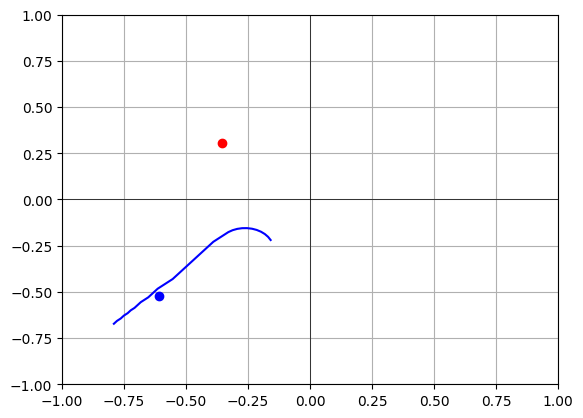

Missile angles:  [2.1096835, 2.2842164, 2.4587493, 2.6332824, 2.8078153, 2.9823482, 3.156881, 3.331414, 3.5059469, 3.6804798, 3.855013, 3.855013, 3.855013, 3.855013, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 4.029546, 3.855013, 3.855013, 3.855013, 3.855013, 4.029546, 4.029546, 4.029546, 3.855013, 3.855013, 4.029546, 4.029546, 3.855013, 4.029546, 3.855013, 4.029546, 3.855013, 4.029546, 3.373927]
Theta angles:  [3.7944567, 3.818797, 3.842758, 3.8658726, 3.887664, 3.9076395, 3.925288, 3.9400797, 3.9514704, 3.9589136, 3.9618793, 3.9650185, 3.9683473, 3.9718826, 3.970023, 3.9680395, 3.9659195, 3.9636483, 3.9612095, 3.9585834, 3.9557476, 3.9526763, 3.949339, 3.9456992, 3.9417143, 3.937333, 3.932493, 3.9367864, 3.9415822, 3.946974, 3.9530797, 3.94764, 3.9413693, 3.9340622, 3.9412055, 3.9497635, 3.9409692, 3.9300032, 3.9406002, 3.925977, 3.9399414, 3.918022, 3.9384315, 3.8949144, 4.413542]


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Logging to ./dqn_missile_guidance_local_v8.1_bone_angle\DQN_0
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.3     |
|    ep_rew_mean      | 1.33e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18372    |
|    fps              | 371      |
|    time_elapsed     | 0        |
|    total_timesteps  | 900162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 611      |
|    n_updates        | 225015   |
----------------------------------
HIT!
HIT!
HIT!
HIT!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.7     |
|    ep_rew_mean      | 1.33e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18376    |
|    fps              | 558      |
|    time_elapsed     | 0        |
|    total_timesteps  | 900348   |
| train/              |

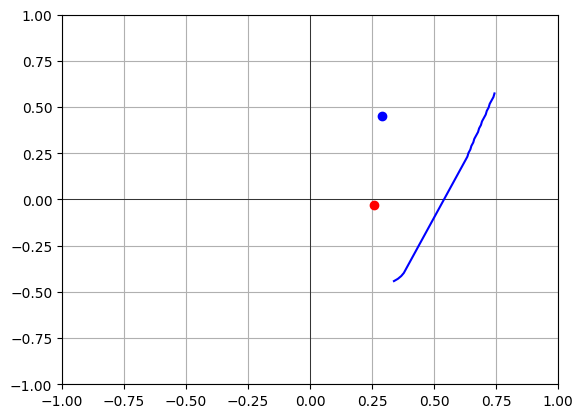

Missile angles:  [0.6605778, 0.8351107, 1.0096437, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.1841766, 1.3587095, 1.1841766, 1.3587095, 1.1841766, 1.3587095, 1.1841766, 1.1841766, 1.3587095, 1.1841766, 1.3587095, 1.1841766, 1.1841766, 1.3587095, 1.1841766, 1.3587095, 1.1841766, 1.1841766, 1.3587095, 4.3370175]
Theta angles:  [1.2010443, 1.2074693, 1.2110616, 1.211562, 1.2120816, 1.2126211, 1.2131819, 1.2137653, 1.2143725, 1.2150053, 1.2156651, 1.2163538, 1.2170732, 1.2178257, 1.2186131, 1.2194384, 1.2203043, 1.2212136, 1.22217, 1.223177, 1.2242388, 1.2253599, 1.2265456, 1.2278016, 1.2291342, 1.2305508, 1.2320594, 1.2336694, 1.2353914, 1.2372375, 1.2392213, 1.2413592, 1.

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

In [8]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
# .........................................................................................................................................................
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
# COPY OF THE CODE ABOVE: THIS VERSION IS FOR TESTING THE ANIMATION FUNCTION 

from copy import deepcopy

log_number = 1

def run_episode(env, model):
    # If you have only one environment wrapped, you can directly access it
    single_env = env.envs[0]
    obs = env.reset()
    done = False
    animate = False
    total_reward = 0
    step = 0
    episode_data = None
    global log_number

    print("EPISODE NUMBER:", log_number)

    episode_data = {
    'past_defense_positions': [], # In upgraded code, we'd only need defense_positions, this is slop, let it work for now
    'attack_positions': [],
    'defense_positions': [], # because you're basically storing the same data in two different places
    'theta': [],
    'missile_angle': [],
    'actions': [],
    }

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        episode_data['actions'].append(deepcopy(action))
        episode_data['past_defense_positions'].append(deepcopy(np.array([obs[0][2], obs[0][3]])))
        obs, reward, done, info = env.step(action)
        episode_data['attack_positions'].append(deepcopy(np.array([obs[0][2], obs[0][3]])))
        episode_data['defense_positions'].append(deepcopy(np.array([obs[0][0], obs[0][1]])))
        episode_data['theta'].append(deepcopy(obs[0][4]))
        episode_data['missile_angle'].append(deepcopy(obs[0][5]))
        total_reward += reward
        step += 1

    print(f"Episode finished in {step} steps with reward {total_reward}. Out of bounds: {single_env.out_of_bounds}, Interceptions: {single_env.interceptions}, Reached max steps: {single_env.reached_max_steps}")

    log_number += 1
    
    if episode_data is not None:
        episode_file_name = f'episode_{log_number}_v8.1_dqn_bone_angle.gif'
        animate_episode(episode_data, episode_file_name)
        print("Missile angles: ", episode_data['missile_angle'])
        print("Theta angles: ", episode_data['theta'])

    # Now access the specific attributes from the single_env which is your actual missile_interception instance
    return step, total_reward, single_env.out_of_bounds, single_env.interceptions, single_env.reached_max_steps

# Create the environment
env = make_vec_env(lambda: missile_interception(), n_envs=1)

# Create the model
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./dqn_missile_guidance_local_v8.1_bone_angle")

# Create a summary writer
summary_writer = tf.summary.create_file_writer('./dqn_missile_guidance_local_v8.1_bone_angle/custom_metrics')

# Training loop
total_timesteps = 1000000
eval_interval = 100000  # Evaluate and log every 10000 steps

for step in range(0, total_timesteps, eval_interval):
    # Train for a number of timesteps
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    
    # Run an evaluation episode
    episode_length, episode_reward, out_of_bounds, interceptions, reached_max_steps = run_episode(env, model)
    
    # Log the results
    with summary_writer.as_default():
        tf.summary.scalar('Evaluation/Episode Length', episode_length, step=step)
        # Ensure episode_reward and other metrics are scalars by using .item() if they are numpy arrays or tensors
        tf.summary.scalar('Evaluation/Episode Reward', episode_reward.item() if isinstance(episode_reward, np.ndarray) else episode_reward, step=step)
        tf.summary.scalar('Evaluation/Out of Bounds Count', out_of_bounds.item() if isinstance(out_of_bounds, np.ndarray) else out_of_bounds, step=step)
        tf.summary.scalar('Evaluation/Interceptions Count', interceptions.item() if isinstance(interceptions, np.ndarray) else interceptions, step=step)
        tf.summary.scalar('Evaluation/Reached Max Steps Count', reached_max_steps.item() if isinstance(reached_max_steps, np.ndarray) else reached_max_steps, step=step)
        summary_writer.flush()


# Save the final model
model.save("dqn_missile_guidance_v8.1_bone_angle")

EPISODE NUMBER: 11
HIT!
Episode finished in 18 steps with reward [10208.292]. Out of bounds: 502, Interceptions: 19841, Reached max steps: 47


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_12_v8.1_dqn_bone_angle.gif


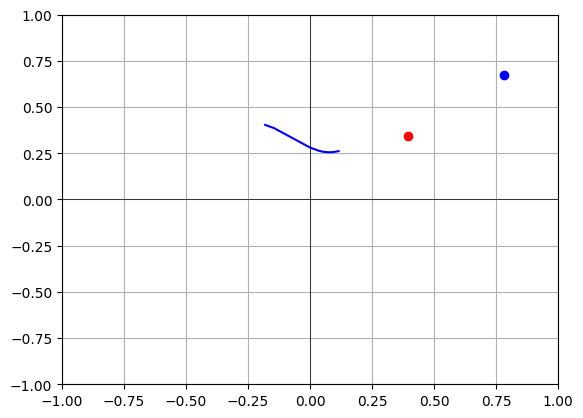

Missile angles:  [3.3873103, 3.2127774, 3.0382445, 2.8637116, 2.6891787, 2.6891787, 2.5146456, 2.5146456, 2.5146456, 2.5146456, 2.5146456, 2.5146456, 2.5146456, 2.5146456, 2.5146456, 2.6891787, 2.6891787, 0.20853364]
Theta angles:  [2.6423187, 2.6106195, 2.5849125, 2.5667765, 2.5581677, 2.5482652, 2.5510218, 2.554271, 2.5581567, 2.5628872, 2.5687702, 2.5762856, 2.5862203, 2.5999632, 2.620214, 2.5987542, 2.5580173, 0.7053779]
EPISODE NUMBER: 12
HIT!
Episode finished in 58 steps with reward [10641.212]. Out of bounds: 502, Interceptions: 19842, Reached max steps: 47


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_13_v8.1_dqn_bone_angle.gif


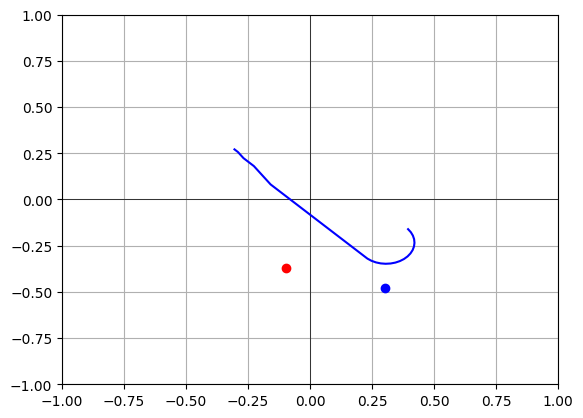

Missile angles:  [5.309313, 5.13478, 4.960247, 4.785714, 4.6111813, 4.436648, 4.262115, 4.087582, 3.9130492, 3.7385163, 3.5639834, 3.3894506, 3.2149177, 3.0403848, 2.8658519, 2.6913188, 2.5167859, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.342253, 2.16772, 2.16772, 2.16772, 2.16772, 2.16772, 2.16772, 2.342253, 2.342253, 2.342253, 2.16772, 2.16772, 2.342253, 1.7949766]
Theta angles:  [2.5603347, 2.5484965, 2.5340428, 2.5174277, 2.4991012, 2.4795063, 2.459079, 2.438249, 2.4174433, 2.3970888, 2.377616, 2.3594613, 2.343069, 2.3288898, 2.3173773, 2.3089807, 2.3041294, 2.3032115, 2.3022485, 2.3012366, 2.3001723, 2.2990515, 2.2978692, 2.2966206, 2.2952998, 2.2939, 2.2924144, 2.290835, 2.289152, 2.2873552, 2.2854326, 2.2833707, 2.281154, 2.2787638, 2.2761793, 2.2733757

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_14_v8.1_dqn_bone_angle.gif


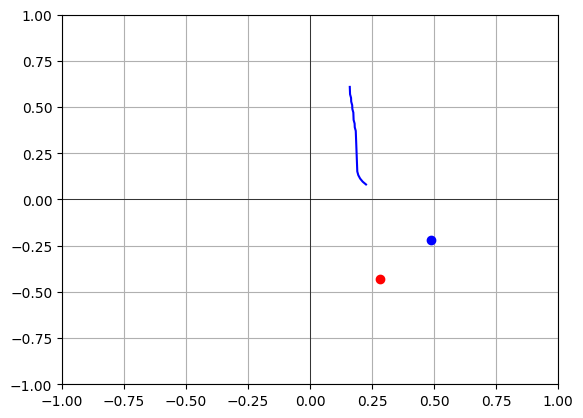

Missile angles:  [2.2970824, 2.1225495, 1.9480166, 1.7734836, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.5989507, 1.7734836, 1.5989507, 1.7734836, 1.5989507, 1.5989507, 1.7734836, 1.5989507, 1.7734836, 1.5989507, 1.7734836, 1.5989507, 1.5989507, 5.089231]
Theta angles:  [1.673642, 1.6576625, 1.6467365, 1.6417226, 1.6434885, 1.6454065, 1.6474969, 1.6497843, 1.6522976, 1.655072, 1.6581506, 1.6615859, 1.665444, 1.6698077, 1.6747831, 1.6673374, 1.6729215, 1.6639918, 1.670336, 1.6780486, 1.6665021, 1.6758056, 1.6602287, 1.6718643, 1.6481024, 1.6631225, 1.6913247, 0.78947264]
EPISODE NUMBER: 14
HIT!
Episode finished in 35 steps with reward [10572.317]. Out of bounds: 502, Interceptions: 19844, Reached max steps: 47


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_15_v8.1_dqn_bone_angle.gif


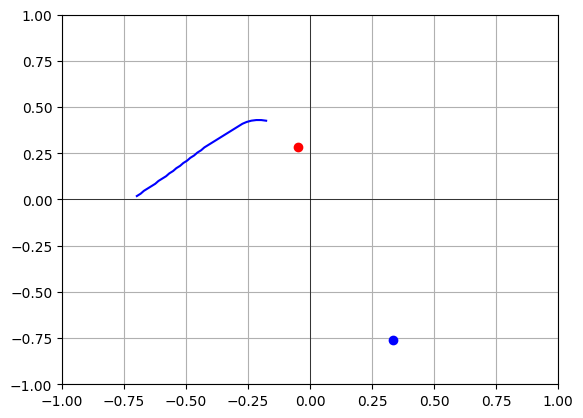

Missile angles:  [2.9638908, 3.1384237, 3.3129566, 3.4874895, 3.6620224, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 3.8365552, 4.0110884, 3.8365552, 4.0110884, 3.8365552, 4.0110884, 3.8365552, 4.0110884, 3.8365552, 4.0110884, 3.8365552, 4.0110884, 3.8365552, 3.8365552, 4.0110884, 3.8365552, 3.8365552, 3.8365552, 4.0110884, 3.8365552, 0.5904086]
Theta angles:  [3.8295777, 3.84824, 3.8635573, 3.874902, 3.8816311, 3.8831136, 3.8846967, 3.8863912, 3.888209, 3.8901644, 3.8922737, 3.8945553, 3.8970318, 3.8997288, 3.9026773, 3.897378, 3.9005082, 3.894519, 3.8978431, 3.8909674, 3.8944905, 3.8864365, 3.8901448, 3.8804564, 3.884288, 3.8722014, 3.8759673, 3.880622, 3.8632154, 3.8673325, 3.8729527, 3.8810823, 3.843896, 3.8468475, 5.0646214]
EPISODE NUMBER: 15
HIT!
Episode finished in 61 steps with reward [5764601.]. Out of bounds: 502, Interceptions: 19845, Reached max steps: 47


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_16_v8.1_dqn_bone_angle.gif


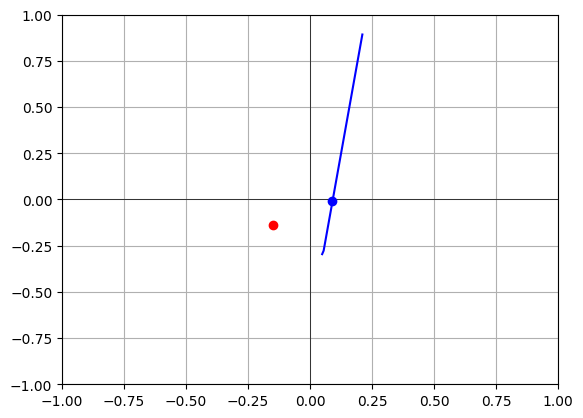

Missile angles:  [1.2636155, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 1.4381484, 3.2962806]
Theta angles:  [1.4381536, 1.4381537, 1.4381539, 1.4381539, 1.438154, 1.4381541, 1.4381542, 1.4381543, 1.4381545, 1.4381546, 1.4381547, 1.4381548, 1.4381549, 1.438155, 1.4381552, 1.4381553, 1.4381555, 1.4381557, 1.4381558, 1.438156, 1.4381561, 1.4381564, 1.4381566, 1.4381567, 1.438157, 1.4381572, 1.4381574, 1.

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_17_v8.1_dqn_bone_angle.gif


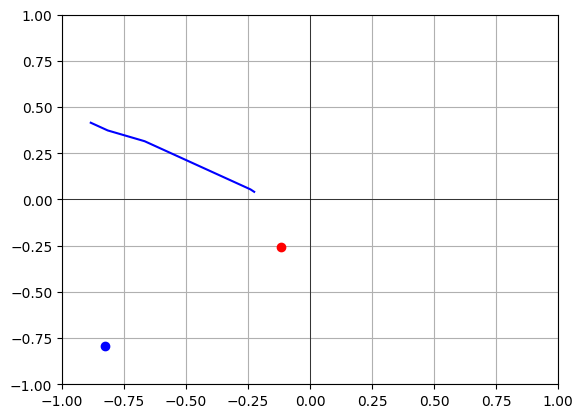

Missile angles:  [2.418859, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.593392, 2.7679248, 2.7679248, 2.7679248, 2.7679248, 2.7679248, 2.7679248, 2.7679248, 2.7679248, 2.593392, 2.593392, 2.593392, 2.593392, 2.4169462]
Theta angles:  [2.6389325, 2.6401207, 2.6413727, 2.6426935, 2.6440892, 2.645566, 2.6471314, 2.6487935, 2.6505616, 2.652446, 2.6544588, 2.6566133, 2.6589255, 2.6614127, 2.664096, 2.6669993, 2.6701505, 2.6735833, 2.6773365, 2.6814575, 2.6860027, 2.691041, 2.6966572, 2.7029557, 2.710069, 2.718165, 2.7144477, 2.710131, 2.705057, 2.699008, 2.6916733, 2.682596, 2.671073, 2.6559668, 2.667539, 2.6843479, 2.7109666, 2.7594097, 3.7879827]
EPISODE NUMBER: 17
HIT!
Episode finished in 86 steps with reward [12831.467]. Out of bounds: 502, Interceptions: 19847, Reached max steps: 47


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_18_v8.1_dqn_bone_angle.gif


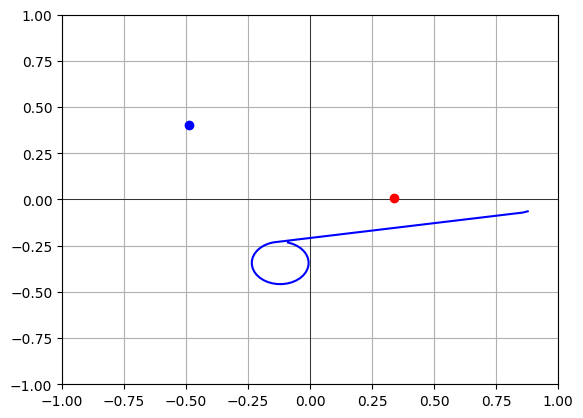

Missile angles:  [5.918659, 5.7441263, 5.5695934, 5.39506, 5.220527, 5.0459943, 4.8714614, 4.6969285, 4.5223956, 4.3478627, 4.17333, 3.998797, 3.824264, 3.649731, 3.475198, 3.3006651, 3.1261322, 2.9515994, 2.7770665, 2.6025336, 2.4280005, 2.2534676, 2.0789347, 1.9044018, 1.7298689, 1.5553359, 1.380803, 1.2062701, 1.0317372, 0.8572042, 0.6826713, 0.50813836, 0.33360544, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.15907253, 0.33360544, 4.06

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_19_v8.1_dqn_bone_angle.gif


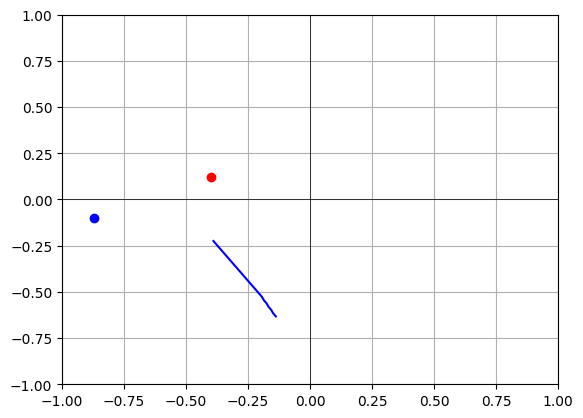

Missile angles:  [5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.28704, 5.1125073, 5.28704, 5.1125073, 5.28704, 5.1125073, 5.28704, 0.6213234]
Theta angles:  [5.254902, 5.25357, 5.2521234, 5.2505455, 5.248819, 5.2469206, 5.2448244, 5.242497, 5.239898, 5.2369776, 5.233671, 5.2298985, 5.225552, 5.220491, 5.214524, 5.2073836, 5.1986876, 5.187867, 5.1983852, 5.184018, 5.1978498, 5.1764917, 5.1966414, 5.1552086, 3.57409]
EPISODE NUMBER: 19
HIT!
Episode finished in 75 steps with reward [11547.955]. Out of bounds: 502, Interceptions: 19849, Reached max steps: 47


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_20_v8.1_dqn_bone_angle.gif


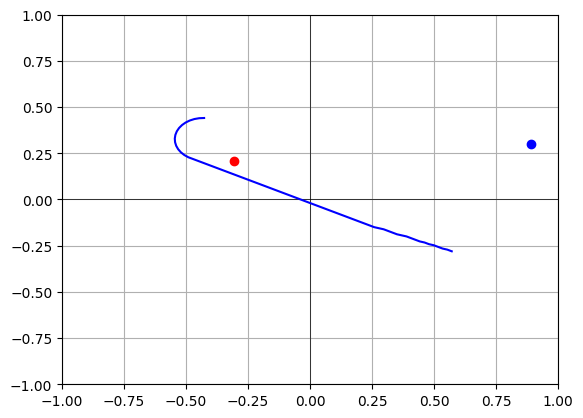

Missile angles:  [3.197734, 3.372267, 3.5468, 3.7213328, 3.8958657, 4.070399, 4.2449317, 4.4194646, 4.5939975, 4.7685304, 4.9430633, 5.117596, 5.292129, 5.466662, 5.641195, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.8157277, 5.990261, 5.990261, 5.8157277, 5.8157277, 5.8157277, 5.990261, 5.990261, 5.8157277, 5.8157277, 5.8157277, 5.990261, 5.8157277, 5.990261, 5.8157277, 5.8157277, 5.990261, 5.8157277, 2.3761098]
Theta angles:  [5.675659, 5.686949, 5.699634, 5.7133784, 5.7278414, 5.742679, 5.7575474, 5.772102, 5.7859993, 5.798898, 5.8104606, 5.8203573, 5.828272, 5.83391, 5.837011, 5.8

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Animation saved as episode_21_v8.1_dqn_bone_angle.gif


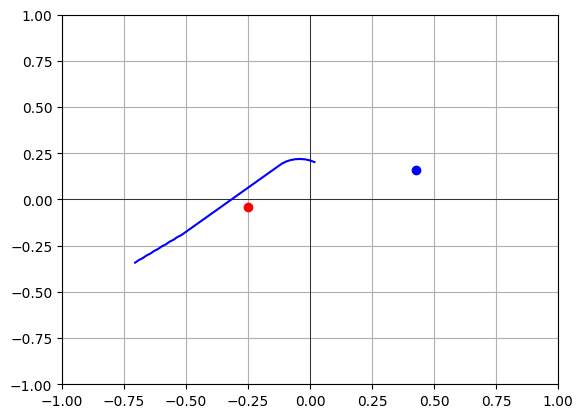

Missile angles:  [2.6819901, 2.856523, 3.031056, 3.2055888, 3.3801217, 3.5546548, 3.7291877, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.9037206, 3.7291877, 3.9037206, 3.7291877, 3.9037206, 3.7291877, 3.9037206, 3.7291877, 3.9037206, 3.7291877, 3.9037206, 3.7291877, 3.9037206, 3.95804]
Theta angles:  [3.8042185, 3.821488, 3.836828, 3.8497915, 3.8599315, 3.866812, 3.8700254, 3.8692174, 3.8683698, 3.8674793, 3.8665428, 3.865557, 3.8645172, 3.8634193, 3.862258, 3.861028, 3.8597229, 3.8583353, 3.8568575, 3.8552804, 3.8535936, 3.8517852, 3.8498414, 3.8477466, 3.8454826, 3.8430278, 3.8403573, 3.8374414, 3.8342447, 3.8307245, 3.8268294, 3.822496, 3.8176465, 3.8121827, 3.8059804, 3.8115633, 3.8043432, 3.8107338, 3.8020995, 3.8095658, 3.7988355

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

In [9]:
# Let's run the episode for 10 episodes
for _ in range(10):
    run_episode(env, model)